In [1]:
#import required libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from scipy.stats import mode
import numpy as np
#from mnist import MNIST
import time as time
import os
%matplotlib inline
from mlxtend.data import loadlocal_mnist
import random
plt.rcdefaults()
from IPython.display import display, HTML
from itertools import chain
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sb
import warnings
warnings.filterwarnings('ignore')
from scipy import optimize as op
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
#read MNIST dataset from python libraries
mnist = input_data.read_data_sets('MNIST_data/')

#fetch features
X_train = mnist.train.images
X_validation = mnist.validation.images
X_test = mnist.test.images

#fetch labels
y_train = mnist.train.labels
y_validation = mnist.validation.labels
y_test = mnist.test.labels

#multiply all feature values to make bring data in range (0,255)
X_train = X_train * 255
X_validation = X_validation * 255
X_test = X_test * 255

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


## Naive Bayes Classification

In [3]:
#Naive Bayes function
def naivebayes(X_train, y_train, X_test, y_test, sm):
    
    #initialize parameters for later use
    m, s, prior, count = [], [], [], []
    
    #loop through all unique classes
    for i, val in enumerate(np.unique(y_train)):
        sep = [y_train == val] 
        count.append(len(y_train[sep]))
        prior.append(len(y_train[sep]) / len(y_train))
        m.append(np.mean(X_train[sep], axis=0))
        s.append(np.std(X_train[sep], axis=0))
    
    #initialize parameters for later use
    pred = []
    lhood = []
    lcs = []
    
    #loop through every testing data rows
    for n in range(len(y_test)):
        nb_classifier = []
        sample = X_test[n]
        ll = []
        
        #loop through all unique classes
        for i, val in enumerate(np.unique(y_train)):
            m1 = m[i]
            var = np.square(s[i]) + sm
            prob = 1 / np.sqrt(2 * np.pi * var) * np.exp(-np.square(sample - m1)/(2 * var))
            result = np.sum(np.log(prob))
            nb_classifier.append(result)
            ll.append(prob)

        #append items into the corresponding list
        pred.append(np.argmax(nb_classifier))
        lhood.append(ll)
        lcs.append(nb_classifier)
    
    #return values
    return pred, lhood

In [4]:
#function to calculate error rate for every digit
def error_rate(confusion_matrix):
    a = confusion_matrix
    b = a.sum(axis=1)  #take sum for each column
    df = []  #initialize list for later us
    
    #loop through all the unique classes
    for i in range(0,10):
        temp = 1-a[i][i]/b[i]
        df.append(round(temp*100,4))
    
    #convert list into dataframe
    df = pd.DataFrame(df)
    df.columns = ['Error rate (%)']
    
    #return dataframe containing list of error % for each digit
    return df

In [5]:
#initialize lists for later use
smoothing = [0.001, 0.01, 0.1, 1, 10, 100,1000,2000,5000,10000]
accuracy_list = []
time_list = []

#loop through each values of smoothing list
for s in smoothing:
    
    #initiate time to calculate time taken by each smoothing value
    tic = time.time()
    
    #run Naive Bayes algorithm to predict best smoothing value
    nb = naivebayes(X_train, y_train, X_validation, y_validation, s)
    
    toc = time.time()
    nb_pred = nb[0]
    
    #append items to the corresponding list
    accuracy_list.append(accuracy_score(y_validation, nb_pred)*100)
    time_list.append(round(toc-tic,4))

### Execution Time

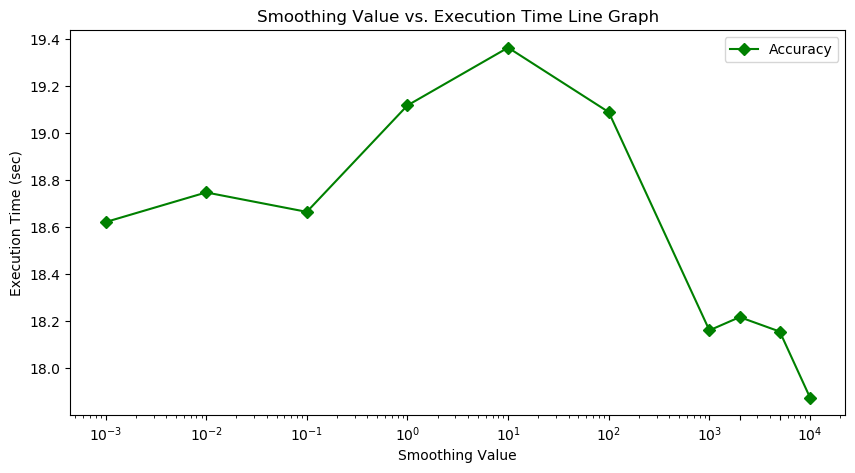

In [6]:
#create a dataframe for total time for below graph
totaltime = pd.DataFrame({'Smoothing Value': smoothing, 'Time (sec)':time_list})

#plot a line graph
plt.subplots(figsize=(10, 5))                                                            #figure size
plt.semilogx(totaltime.iloc[:,0], totaltime.iloc[:,1],'-gD' , label="Accuracy")          #plot graph
plt.xlabel("Smoothing Value")                                                            #xlabel
plt.ylabel("Execution Time (sec)")                                                       #ylabel
plt.legend()                                                                             #legend
plt.xticks(totaltime.iloc[:,0])                                                          #xticks
plt.title('Smoothing Value vs. Execution Time Line Graph')                               #title
plt.show()                                                                               #display the graph

### Accuracy Matrix

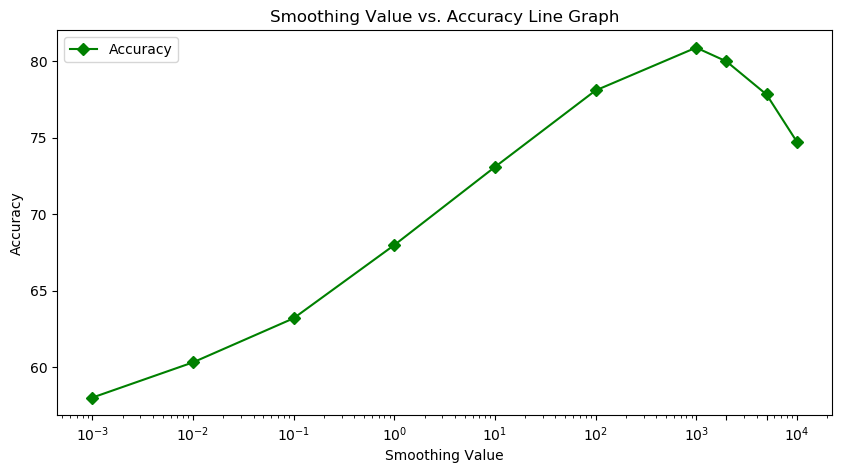

In [7]:
plt.subplots(figsize=(10, 5))                                          #figure size
plt.semilogx(smoothing, accuracy_list,'-gD' , label="Accuracy")        #plot graph
plt.xlabel("Smoothing Value")                                          #xlabel
plt.ylabel("Accuracy")                                                 #ylabel
plt.legend()                                                           #legend
plt.xticks(smoothing)                                                  #xticks
plt.title('Smoothing Value vs. Accuracy Line Graph')                   #title
plt.show()                                                             #display the graph

In [8]:
#calculate best smoothing value
best_smoothing = smoothing[np.argmax(accuracy_list)]
print('Best Smoothing Value based on maximum accuracy: ',best_smoothing)

Best Smoothing Value based on maximum accuracy:  1000


### Test Accuracy

In [9]:
#concatenate train and validation set for the final model training
X_train = np.concatenate((X_train, X_validation), axis=0)
y_train = np.concatenate((y_train, y_validation), axis=0)

#run Naive Bayes to predict the values for the testing dataset
nb = naivebayes(X_train, y_train, X_test, y_test, best_smoothing)
nb_pred = nb[0]  #fetch prediction

#calculate the accuracy score
acc = accuracy_score(y_test, nb_pred)*100
print('Total Test Accuracy: ', acc, '%')

Total Test Accuracy:  81.49 %


### Confusion Matrix

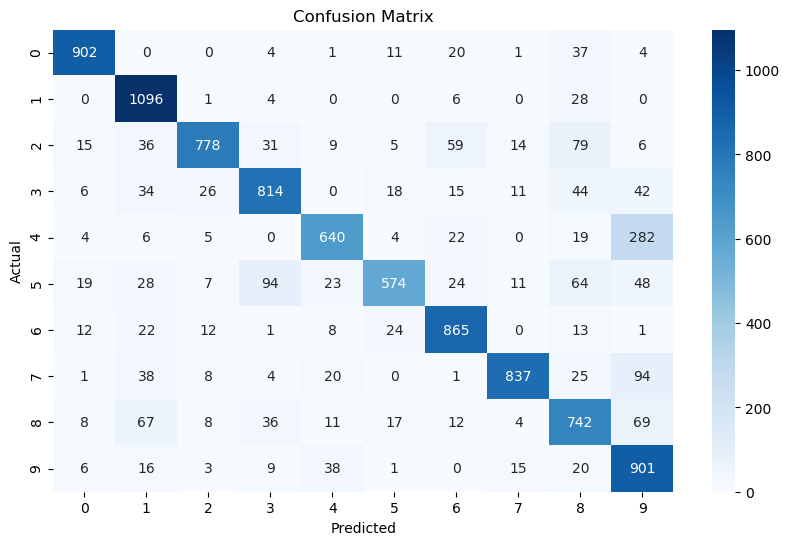

In [10]:
#calculate the confusion matrix for the testing dataset
cm = confusion_matrix(y_test, nb_pred)

#print the confusion matrix
plt.subplots(figsize=(10, 6))                                              #figure size
sb.heatmap(cm, annot = True, fmt = 'g', cbar=True, cmap='Blues')           #plot heatmap
plt.xlabel("Predicted")                                                    #xlabel
plt.ylabel("Actual")                                                       #ylabel
plt.title("Confusion Matrix")                                              #title
plt.show()                                                                 #display the heatmap

### Accuracy for each Digit

In [11]:
#display the error rate for each digit
a = error_rate(cm)
a.T

,0,1,2,3,4,5,6,7,8,9
Error rate (%),7.9592,3.4361,24.6124,19.4059,34.8269,35.6502,9.7077,18.5798,23.8193,10.7037


### Image clasified using Naive Bayes

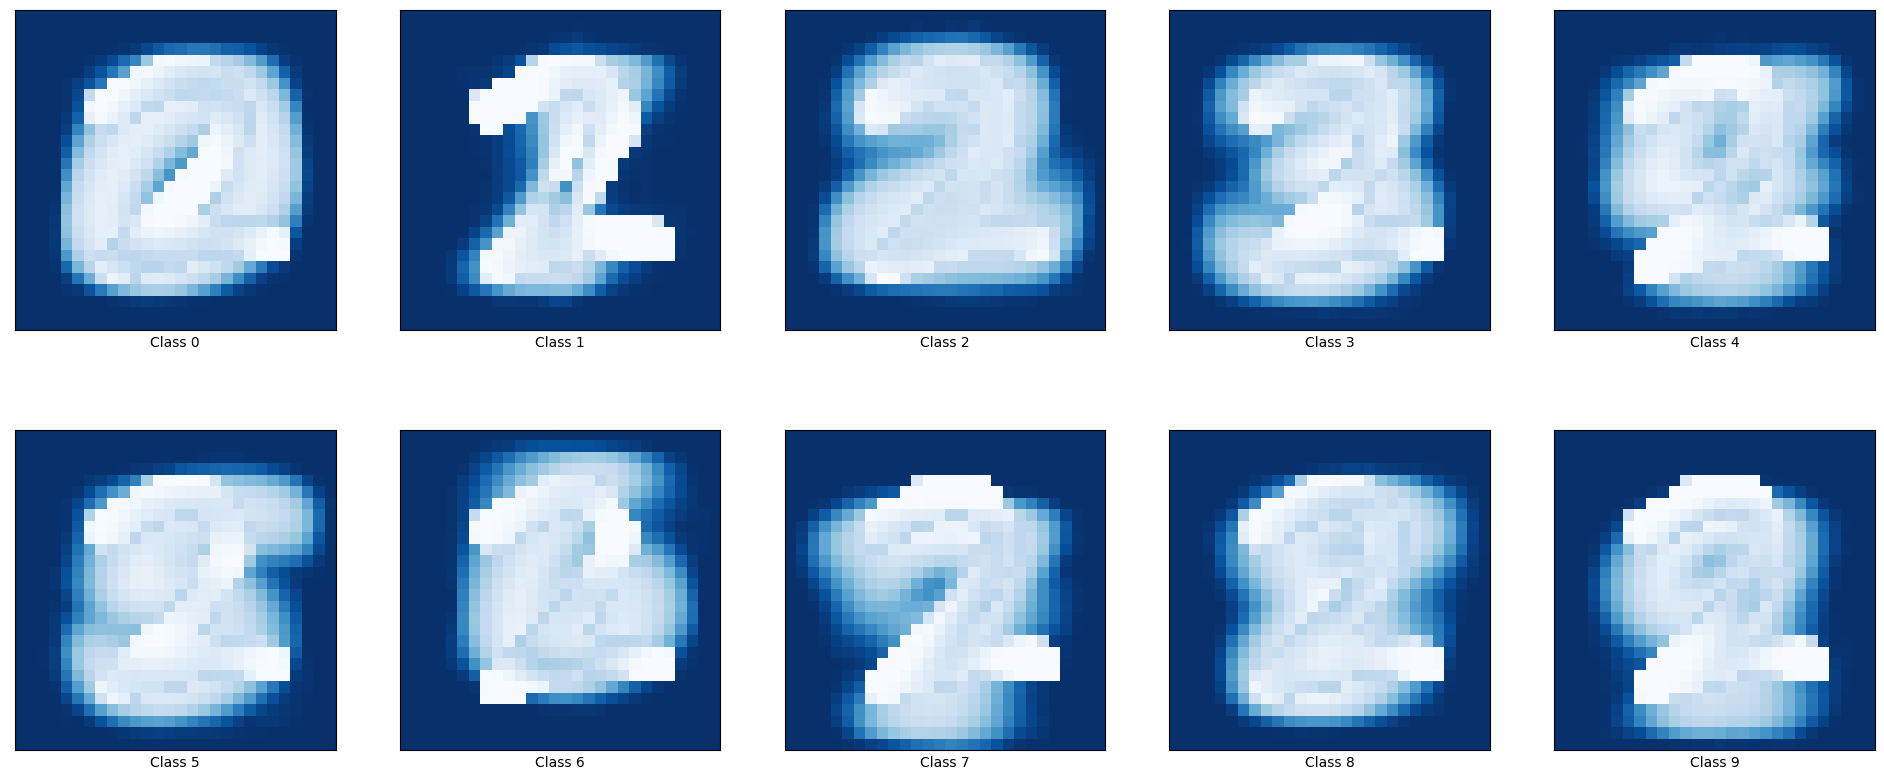

In [12]:
#displaying an image of the 784 conditional probabilities as a 28*28 image
l = nb[1]
m = l[9995]
plt.subplots(2,5, figsize=(24,10))                                                        #figure size

#loop through all the unique classes
for i in range(10):                                 
    l1 = plt.subplot(2, 5, i + 1)                                                        #plot graph
    l1.imshow(m[i].reshape(28, 28), cmap='Blues', interpolation='nearest')               #show image
    l1.set_yticks(())                                                                    #yticks
    l1.set_xticks(())                                                                    #xticks
    l1.set_xlabel('Class %i' % i)                                                        #xlabel
plt.show()                                                                               #display image

## Logistic Regression Classification

In [13]:
#read the dataset given in the question
trainData, trainLabels = loadlocal_mnist(
        images_path='../train-images.idx3-ubyte', 
        labels_path='../train-labels.idx1-ubyte')
testData, testLabels =loadlocal_mnist(
        images_path='../t10k-images.idx3-ubyte', 
        labels_path='../t10k-labels.idx1-ubyte')

#print the shape of each dataframe
print('trainData.shape: ',trainData.shape)       #training data
print('trainLabels.shape: ',trainLabels.shape)   #training labels
print('testData.shape: ',testData.shape)         #testing data
print('testLabels.shape: ',testLabels.shape)     #testing labels

trainData.shape:  (60000, 784)
trainLabels.shape:  (60000,)
testData.shape:  (10000, 784)
testLabels.shape:  (10000,)


In [14]:
#initialize variables and lists for later use
tic = time.time()
accuracy = []
cm = []
classifier_list = []
time_list = []
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

#loop through each alpha (regularization parameter) values
for a in alpha:
    
    #save time info to calculate time execution time for each alpha
    tic = time.time()
    
    #create an object of the Logistic Regression class
    #fit_intercept=True specifies if a constant (a.k.a. bias or intercept) should be added to the decision function.
    #In the multiclass case, the training algorithm uses the one-vs-rest (OvR) scheme by setting multi_class='ovr' option 
    #penalty='l2' parameter is set for Ridge Regression
    classifier = LogisticRegression(C=a, class_weight=None, dual=False, fit_intercept=True,
              intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
              penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
              verbose=0, warm_start=False)
    
    #fit the model with training dataset
    classifier.fit(trainData, trainLabels)
    
    #predict values for testing dataset
    y_pred = classifier.predict(testData)
    
    #append information into their corresponding lists
    time_list.append(time.time()-tic)
    classifier_list.append(classifier)
    accuracy.append(accuracy_score(testLabels, y_pred))
    cm.append(confusion_matrix(testLabels, y_pred))

### Accuracy Matrix

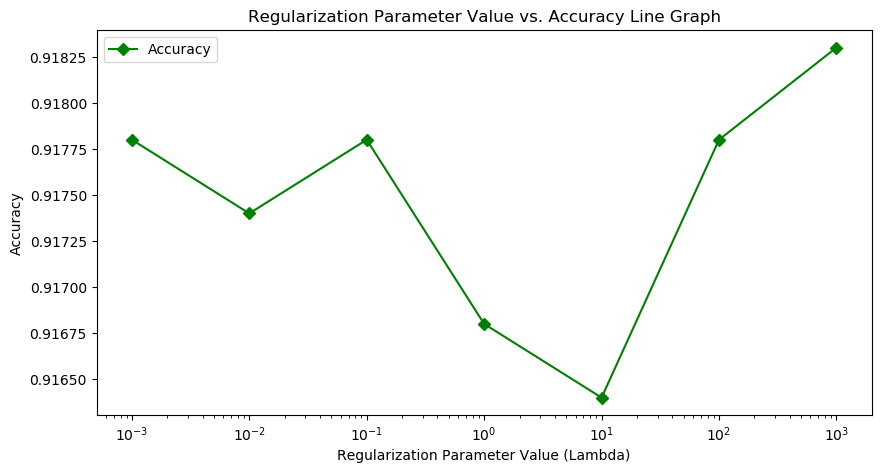

In [15]:
#plot the graph for alpha values vs. accuracy
plt.subplots(figsize=(10, 5))                                           #figure size
plt.semilogx(alpha, accuracy,'-gD' , label="Accuracy")                  #plot graph
plt.xlabel("Regularization Parameter Value (Lambda)")                   #xlabel
plt.ylabel("Accuracy")                                                  #ylabel
plt.legend()                                                            #legend
plt.xticks(alpha)                                                       #xticks
plt.title('Regularization Parameter Value vs. Accuracy Line Graph')     #title
plt.show()                                                              #display the graph

### Best Accuracy Value

In [26]:
#fetch the best accuracy details
best_accuracy = accuracy[np.argmax(accuracy)]
print('Best Accuracy Value: ',best_accuracy*100)

Best Accuracy Value:  91.83


### Confusion Matrix

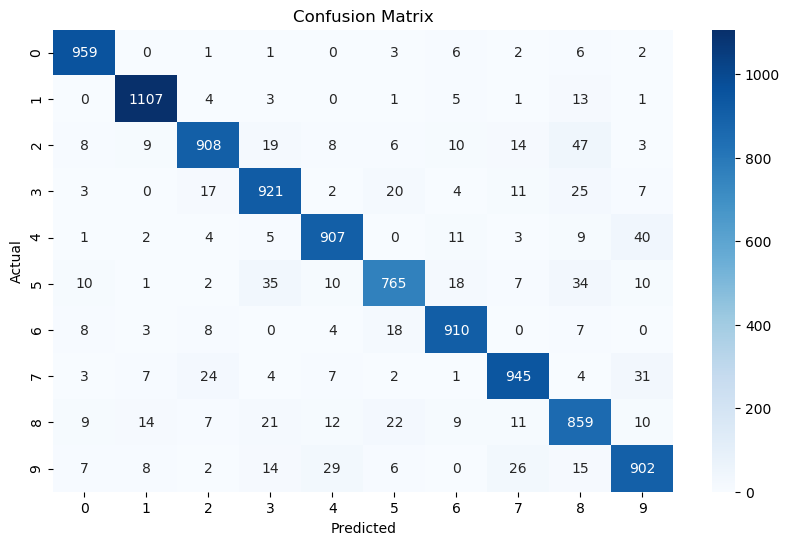

In [21]:
cm[np.argmax(accuracy)]

#calculate the confusion matrix for the testing dataset
cm = cm[np.argmax(accuracy)]

#print the confusion matrix
plt.subplots(figsize=(10, 6))                                              #figure size
sb.heatmap(cm, annot = True, fmt = 'g', cbar=True, cmap='Blues')           #plot heatmap
plt.xlabel("Predicted")                                                    #xlabel
plt.ylabel("Actual")                                                       #ylabel
plt.title("Confusion Matrix")                                              #title
plt.show() 

### Accuracy for each Digit

In [23]:
#display the error rate for each digit
a = error_rate(cm)
a.T

,0,1,2,3,4,5,6,7,8,9
Error rate (%),2.1429,2.467,12.0155,8.8119,7.6375,14.2377,5.0104,8.0739,11.807,10.6046


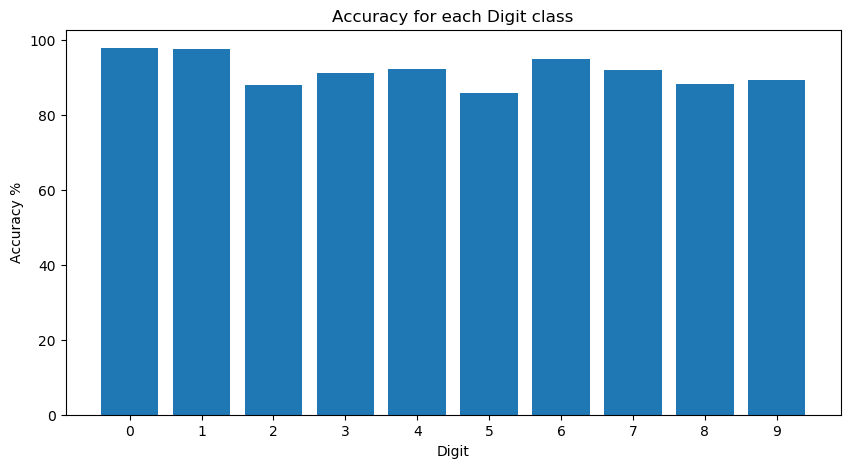

In [17]:
#plot the graph for accuracy of each digits
i = np.argmax(accuracy)                                           #best accuracy index value
plt.figure(figsize=(10,5))                                        #figure size
plt.plot(range(0,10),(cm[i].diagonal()/cm[i].sum(axis=1))*100)     #plot the graph
plt.xticks(range(0,10));                                          #xticks
plt.xlabel('Digit')                                               #xlabel
plt.ylabel('Accuracy %')                                          #ylabel
plt.title('Accuracy for each Digit class')                        #title
plt.show()                                                        #display the graph

### Image classification using Logistic Regression

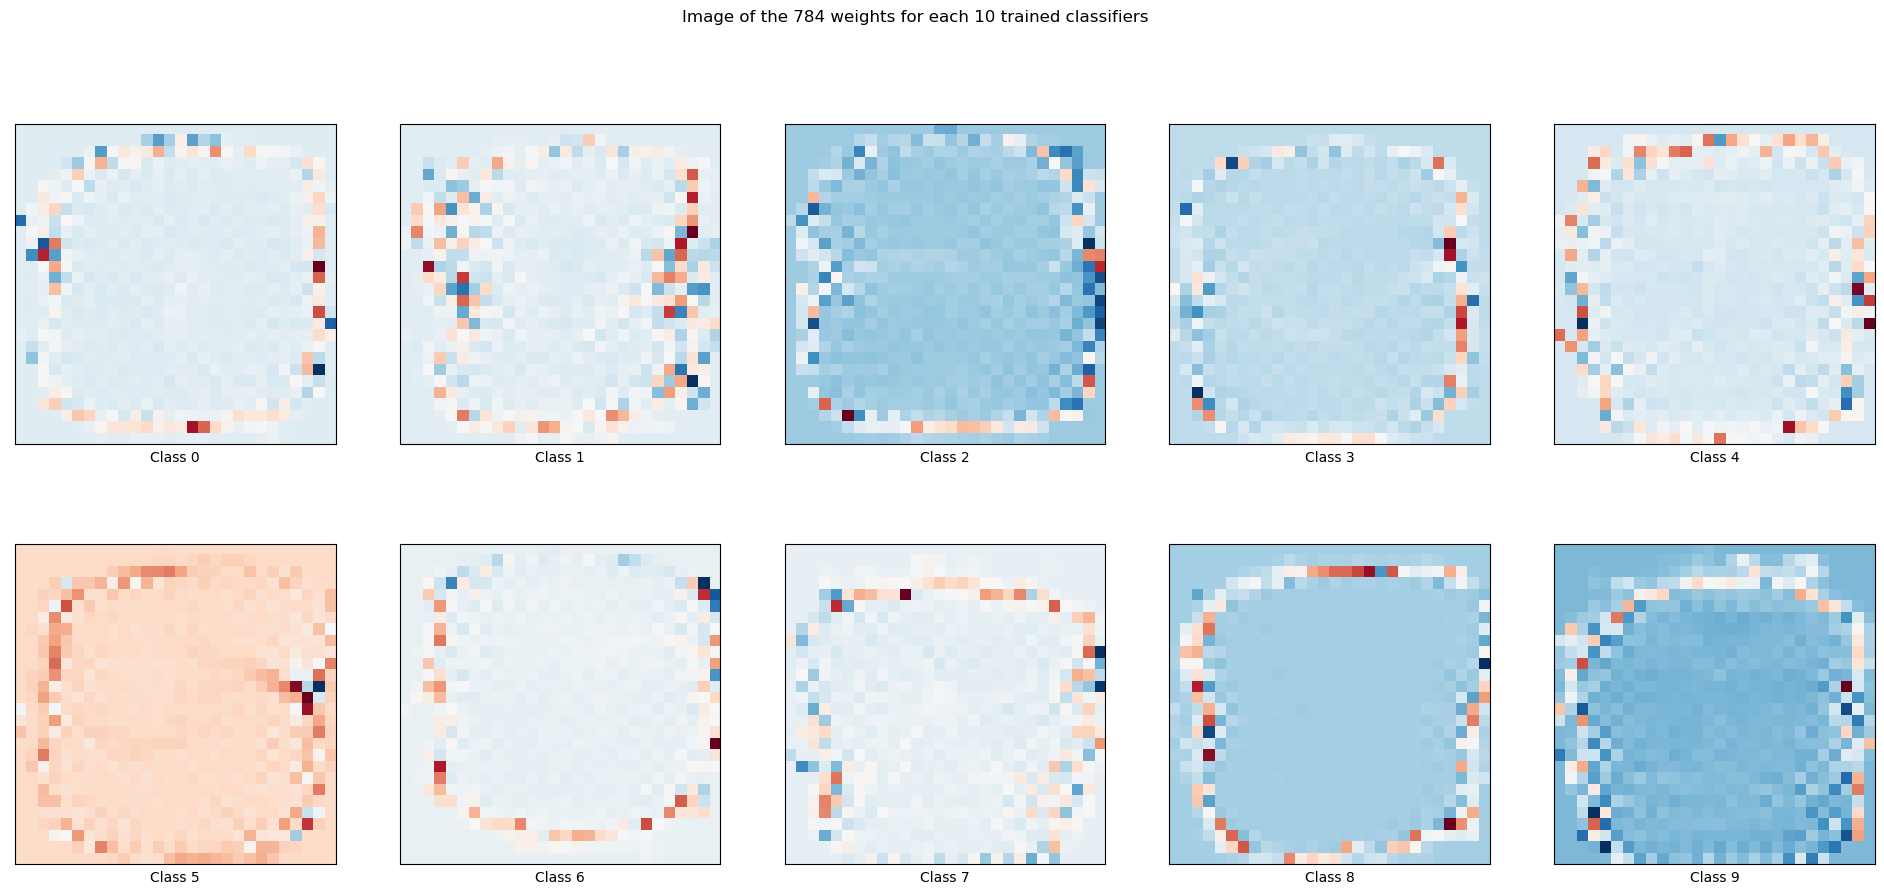

In [18]:
#display the Image of the 784 weights for each 10 trained classifiers
plt.subplots(2,5, figsize=(24,10))                                                                      #figure size

#loop through each digit class
for i in range(10):
    l1 = plt.subplot(2, 5, i + 1)                                                   #align 10 plots in 5*2 fashion
    l1.imshow(classifier_list[np.argmax(accuracy)].coef_[i].reshape(28, 28), interpolation='nearest',cmap=plt.cm.RdBu)    #display image
    l1.set_xticks(())                                                               #xticks
    l1.set_yticks(())                                                               #yticks
    l1.set_xlabel('Class %i' % i)                                                   #xlabel
plt.suptitle('Image of the 784 weights for each 10 trained classifiers')            #title
plt.show()                                                                          #display the graph

### Misclassified Images using Logistic Regression

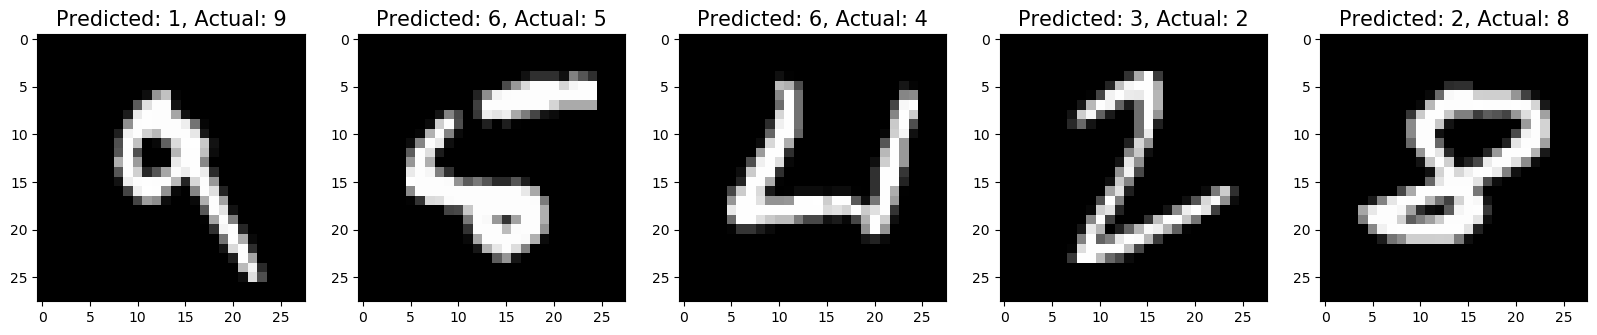

In [19]:
#initialize variable and list for the later use
index = 0
misclassifiedIndexes = []

#loop through each test labels
for label, pred in zip(testLabels, y_pred):
    
    #check if the test label and predicted label matches or not
    if label != pred: 
        misclassifiedIndexes.append(index)   #add into list if not match
    index +=1                                #increment the index by 1
    
#plot the images which are classified wrongly
plt.figure(figsize=(20,4))                                                           #figure size

#loop through each wrongly classified image
for plotIndex, badIndex in enumerate(misclassifiedIndexes[0:5]):                     
    plt.subplot(1, 5, plotIndex + 1)                                                 #display the image in 5*1 fashion
    plt.imshow(np.reshape(testData[badIndex], (28,28)), cmap=plt.cm.gray)            #display the image
    plt.title('Predicted: {}, Actual: {}'.format(y_pred[badIndex], testLabels[badIndex]), fontsize = 15)  #title